# CNN for rock-paper-scissors with Keras/TensorFlow (DCT Type-II)

Date: January 9, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for CNN

In [348]:
DATA_FOLDER = '../thermography/data/'

FILES = 45
TRAINING_FILES = 30 
TEST_FILES = FILES - TRAINING_FILES

In [349]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp
from scipy.fftpack import dct, idct

In [350]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((data, class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((data, class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


(array([ 0.02113671,  3.85340149, -1.67592492, -1.29185413,  0.13513487,
        -0.46931574,  3.0537695 ,  0.83452816, -0.92565225, -0.72062464,
         0.0779169 ,  0.22095335, -1.59418904, -1.01484841,  0.05078066,
         0.47816897,  0.1135445 ,  0.18851234,  0.41710771,  0.12324441,
        -0.14800846,  0.45423572,  0.10677277, -0.24729157, -0.16077523,
        -0.54820422, -0.38339936, -0.16285987, -0.01524567,  0.08330213,
        -0.10030855, -0.20210472, -0.15906752, -0.18682663, -0.12929434,
        -0.07671494]), array([1., 0., 0.], dtype=float32))

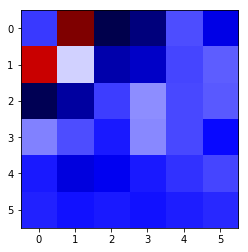

In [351]:
CUTOFF=6
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    img = img.reshape(8,8)
    img = dct(dct(img, norm='ortho').T, norm='ortho').T
    img[0,0] = 0
    img = img[:CUTOFF,:CUTOFF].flatten()
    img = pp.scale(img)    
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    img = img.reshape(8,8)
    img = dct(dct(img, norm='ortho').T, norm='ortho').T
    img[0,0] = 0
    img = img[:CUTOFF,:CUTOFF].flatten()
    img = pp.scale(img)
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data)
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data)
test_lables = np.array(test_labels, dtype='uint8')

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12].reshape((CUTOFF,CUTOFF)), cmap='seismic')
train_data[12], train_labels[12]

### CNN model

In [352]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Dense(int(CUTOFF**2*1.5), activation='relu', input_shape=(CUTOFF**2,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(int(CUTOFF**2*1.5), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 54)                1998      
_________________________________________________________________
dropout_90 (Dropout)         (None, 54)                0         
_________________________________________________________________
dense_127 (Dense)            (None, 54)                2970      
_________________________________________________________________
dropout_91 (Dropout)         (None, 54)                0         
_________________________________________________________________
dense_128 (Dense)            (None, 3)                 165       
Total params: 5,133
Trainable params: 5,133
Non-trainable params: 0
_________________________________________________________________


In [353]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

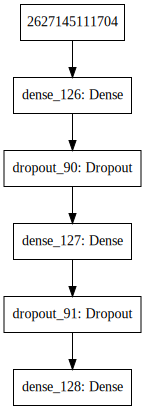

In [354]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [355]:
EPOCHS = 100
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 90 samples, validate on 45 samples
Epoch 1/100
90/90 [==============================] - 1s 16ms/step - loss: 1.1254 - acc: 0.4667 - val_loss: 1.0161 - val_acc: 0.4667
Epoch 2/100
90/90 [==============================] - 0s 141us/step - loss: 1.2442 - acc: 0.4444 - val_loss: 0.9805 - val_acc: 0.5333
Epoch 3/100
90/90 [==============================] - 0s 166us/step - loss: 1.0744 - acc: 0.4556 - val_loss: 0.9569 - val_acc: 0.6000
Epoch 4/100
90/90 [==============================] - 0s 166us/step - loss: 1.1186 - acc: 0.4333 - val_loss: 0.9314 - val_acc: 0.6444
Epoch 5/100
90/90 [==============================] - 0s 155us/step - loss: 1.0934 - acc: 0.4778 - val_loss: 0.9090 - val_acc: 0.6444
Epoch 6/100
90/90 [==============================] - 0s 188us/step - loss: 0.9958 - acc: 0.4889 - val_loss: 0.8943 - val_acc: 0.6667
Epoch 7/100
90/90 [==============================] - 0s 233us/step - loss: 1.0458 - acc: 0.5333 - val_loss: 0.8717 - val_acc: 0.7111
Epoch 8/100
90/90 [=======

Epoch 62/100
90/90 [==============================] - 0s 100us/step - loss: 0.3172 - acc: 0.9000 - val_loss: 0.2330 - val_acc: 0.9333
Epoch 63/100
90/90 [==============================] - 0s 111us/step - loss: 0.3653 - acc: 0.8889 - val_loss: 0.2276 - val_acc: 0.9556
Epoch 64/100
90/90 [==============================] - 0s 155us/step - loss: 0.3217 - acc: 0.9222 - val_loss: 0.2197 - val_acc: 0.9333
Epoch 65/100
90/90 [==============================] - 0s 166us/step - loss: 0.3717 - acc: 0.8333 - val_loss: 0.2131 - val_acc: 0.9556
Epoch 66/100
90/90 [==============================] - 0s 122us/step - loss: 0.3146 - acc: 0.9000 - val_loss: 0.2068 - val_acc: 0.9556
Epoch 67/100
90/90 [==============================] - 0s 100us/step - loss: 0.3868 - acc: 0.8667 - val_loss: 0.1975 - val_acc: 0.9556
Epoch 68/100
90/90 [==============================] - 0s 144us/step - loss: 0.2875 - acc: 0.8778 - val_loss: 0.1957 - val_acc: 0.9556
Epoch 69/100
90/90 [==============================] - 0s 155us

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


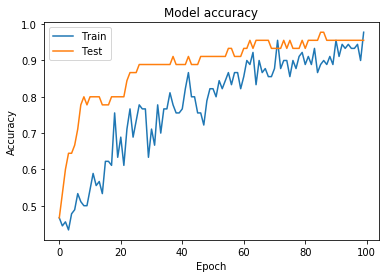

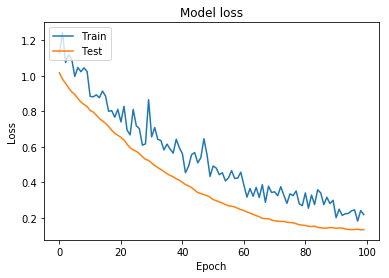

In [356]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [357]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_rock_paper_scissors{}.h5'.format(dt)
model.save(filename)

## Load the model

In [358]:
del model
model = models.load_model(filename)

## Confirmation

In [359]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(90, 36)

In [360]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [361]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [362]:
class_labels

['paper', 'rock', 'scissors']

In [363]:
(activations[-1][:10]*100).astype(int)

array([[99,  0,  0],
       [ 0, 99,  0],
       [ 8, 85,  5],
       [ 4,  3, 92],
       [ 7,  2, 90],
       [ 0, 99,  0],
       [ 0, 99,  0],
       [ 1, 97,  1],
       [ 1,  1, 96],
       [99,  0,  0]])

In [364]:
test_labels[:10].astype(int)

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]])